In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision

In [2]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
datapath = "data/binMNIST"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def binarized_mnist_fixed_binarization(datapath, M):
    """
    Create a dictionnary with the Dataloader
    for the different split of the
    the binarized MNSIT
    
    inputs
        datapath: The path of the data
        M: batch_size
    """
    
    dataloader = {}
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    with open(os.path.join(datapath, 'binarized_mnist_train.amat')) as f:
        lines = f.readlines()
    train_data = lines_to_np_array(lines).astype('float32')
    with open(os.path.join(datapath, 'binarized_mnist_valid.amat')) as f:
        lines = f.readlines()
    validation_data = lines_to_np_array(lines).astype('float32')
    with open(os.path.join(datapath, 'binarized_mnist_test.amat')) as f:
        lines = f.readlines()
    test_data = lines_to_np_array(lines).astype('float32')
    
    dataloader["Train"] = utils.DataLoader(utils.TensorDataset(torch.from_numpy(train_data)), M)
    dataloader["Validation"] = utils.DataLoader(utils.TensorDataset(torch.from_numpy(validation_data)), M)
    dataloader["Test"] = utils.DataLoader(utils.TensorDataset(torch.from_numpy(test_data)), M)

    return dataloader

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_size=100, device=device):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        self.device = device
        
        #Encoder
        self.encoder = nn.Sequential(nn.Conv2d(1, 32, 3), 
                                      nn.ReLU(), 
                                      nn.AvgPool2d(2,2), 
                                      nn.Conv2d(32, 64, 3), 
                                      nn.ReLU(), 
                                      nn.AvgPool2d(2, 2),
                                      nn.Conv2d(64, 256, 5),
                                      nn.ReLU())
        
        self.encoder_var = nn.Linear(256, latent_size)
        self.encoder_mean = nn.Linear(256, latent_size)
        
        #Decoder
        self.decoder_lin = nn.Linear(100, 256)
        self.decoder = nn.Sequential( nn.ReLU(),
                                      nn.Conv2d(256, 64, 5, padding=(4, 4)),
                                      nn.ReLU(),
                                      nn.UpsamplingBilinear2d(scale_factor=2),
                                      nn.Conv2d(64, 32, 3, padding=(2, 2)),
                                      nn.ReLU(),
                                      nn.UpsamplingBilinear2d(scale_factor=2),
                                      nn.Conv2d(32, 16, 3, padding=(2, 2)),
                                      nn.ReLU(),
                                      nn.Conv2d(16, 1, 3, padding=(2, 2))
                                      )
        
    def latent_variable(self, mean, logvar):
        noise = torch.randn_like(mean, device=self.device)
        return noise*torch.exp(0.5*logvar) + mean
    
    def _encoder(self, x):
        """
        Encoder Part of the VAE
        """
        x = self.encoder(x)
        x = x.view(-1, 256).squeeze()
        mean = self.encoder_mean(x)
        logvar = self.encoder_var(x)
        return mean, logvar
    
    def _decoder(self, z):
        """
        Decoder Part of the VAE
        """
        image = self.decoder_lin(z).view(-1, 256).unsqueeze(2).unsqueeze(3)
        image =  self.decoder(image)
        return image.squeeze().view(-1,28*28)
    
    def forward(self, input):
        input = input.view(-1,28,28).unsqueeze(1)
        mean, logvar = self._encoder(input)
        z = self.latent_variable(mean, logvar)
        image = self._decoder(z)
       
        return image, mean, logvar
    
    def gen_noise_for_loglikelihood(self, x, K):
        """
        Used with the loglikelihood function 
        to evaluate the loglikelihood.
        Generate an array Z of size (M,K,L)
        Where M is minibatch size
        K is a the number of importance samples
        L is the dimension of the latent variable
        
        where z_ik comes from q(z|x_i)
        """
        Z = []
        # Parameters for q(z|x) for each examples in the minibatch
        mean, logvar = model._encoder(x.view(-1,28,28).unsqueeze(1))
        
        # For each each examples in the minibatch
        for i in range(x.size(0)):
            zi = torch.randn((K,self.latent_size),
                             device=device)*torch.exp(0.5*logvar[i]) + mean[i]
            Z.append(zi.unsqueeze(0))
        Z = torch.cat(Z, dim=0)
        return Z
    
    def loglikelihood(self, x_i, z_i):
        """
        Evaluate the log-likelihood of the VAE
        inputs:
        An (M,D) array of xi’s.
        An (M,K,L).  array ofzik’s
        
        Returns:
        (logp(x1),...,logp(xM)) estimates of size (M,))
        """
        log_likelihood = []
        criteria = torch.nn.BCEWithLogitsLoss(reduction='none') 

        with torch.set_grad_enabled(False):
            
            # Parameters for q(z|x) for each examples in the minibatch
            mean, logvar = self._encoder(x_i.view(-1,28,28).unsqueeze(1))
            M = z_i.size(0)
            K = z_i.size(1)
            L = z_i.size(2)
            D = x_i.size(1)
            
            # Create p(z) distribution
            pz = torch.distributions.multivariate_normal.MultivariateNormal(
                    torch.zeros(L, device=self.device), torch.eye(L, device=self.device))
            
            # For each each examples in the minibatch
            for m in range(M):
                
                # Create q(z_m|x_m) distribution 
                qz_x = torch.distributions.multivariate_normal.MultivariateNormal(
                        mean[m], torch.exp(logvar[m])*torch.eye(L, device=self.device))

                # Calculate log p(x_m|z_m)
                generated_image = self._decoder(z_i[m])
                logpx_z = torch.sum(
                    -criteria(
                        generated_image,
                        x_i[m]*torch.ones((K,D),device=self.device))
                    ,dim=1)
                
                # Calculate log p(z_m)
                logpz = pz.log_prob(z_i[m])
                
                # Calculate log q(z_m|x_m)
                logqz_x = qz_x.log_prob(z_i[m])
                
                # Calculate log[p(x_m|z_m)p(z_m)/q(z_m|x_m)]
                px = logpx_z + logpz - logqz_x
                
                # Apply logsumexp trick to avoid numerical issue
                pi = torch.max(px)
                px = px-pi
                # Calculate log[1/K sum_{m=1}^{m=K}(p(x_m|z_m)p(z_m)/q(z_m|x_m))]
                logpx = torch.log(torch.sum(torch.exp(px))) + pi - torch.log(
                    torch.tensor([K], device=self.device, dtype=torch.float))
                
                #Add the estimation of log(p(x_m)) to the output vector
                log_likelihood.append(logpx)

        return torch.cat(log_likelihood, dim=0)

In [6]:
def train(model, optimizer,  device, nb_epoch=20):
    """
    Function to train the VAE model
    """
    ELBO_hist = {}
    ELBO_hist["Train"] = []
    ELBO_hist["Validation"] = []
    criteria = torch.nn.BCEWithLogitsLoss(reduction='sum')
    loss = {}
    
    for epoch in range(nb_epoch):
        for stage in ["Train", "Validation"]:
            loss[stage] = 0
            if stage == "Train":
                model.train()
            else:
                model.eval()
            
            for batch in dataloader[stage]:
                optimizer.zero_grad()
                data = batch[0]
                data = data.to(device)
                
                with torch.set_grad_enabled(stage == "Train"):
                    image, mean, logvar = model(data)

                    reconstruction_loss = criteria(image, data)
                    regularisation = -0.5*torch.sum(1 + logvar - torch.pow(mean,2) -torch.exp(logvar))
                    ELBO = reconstruction_loss + regularisation
                
                if stage == "Train":
                    ELBO.backward()
                    optimizer.step()
                
                loss[stage] -= ELBO.item()
                
            ELBO_cum = loss[stage]/len(dataloader[stage].dataset)
            ELBO_hist[stage].append(ELBO_cum) 
            print(f"{epoch} out of {nb_epoch}")
            print(stage)
            print(f"ELBO {ELBO_cum}")

In [7]:
def evaluate(model, device=device):
    """
    Function to evaluate a VAE 
    using both ELBO and log-likelihood estimation
    using importance sampling.
    On Validation and test data.
    """
    ELBO_total = {}
    log_likelihood = {}
    model.eval()
    criteria = torch.nn.BCEWithLogitsLoss(reduction='sum')
    
    for stage in ["Validation","Test"]:
        ELBO_total[stage] = 0
        log_likelihood[stage] = 0
        
        for batch in dataloader[stage]:
            data = batch[0]
            data = data.to(device)

            with torch.set_grad_enabled(False):
                image, mean, logvar = model(data)

                reconstruction_loss = criteria(image, data)
                regularisation = -0.5*torch.sum(1 + logvar - torch.pow(mean,2) -torch.exp(logvar))
                ELBO = reconstruction_loss + regularisation
                
                z_i = model.gen_noise_for_loglikelihood(data, 200)
                log_likelihood[stage] += model.loglikelihood(data, z_i).sum().item()
                ELBO_total[stage] -= ELBO.item()

        ELBO_total[stage] = ELBO_total[stage]/len(dataloader[stage].dataset)
        log_likelihood[stage] = log_likelihood[stage]/len(dataloader[stage].dataset)
        print(f"Dataset {stage} ELBO: {ELBO_total[stage]} Log-likelihood: {log_likelihood[stage]}")

In [8]:
dataloader = binarized_mnist_fixed_binarization(datapath, 128)
model = VAE()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)

In [9]:
train(model, optimizer,  device, nb_epoch=300)

C:\Users\user\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


0 out of 300
Train
ELBO -238.8957648828125
0 out of 300
Validation
ELBO -182.60863076171876
1 out of 300
Train
ELBO -164.093668046875
1 out of 300
Validation
ELBO -155.30106372070313
2 out of 300
Train
ELBO -145.838933515625
2 out of 300
Validation
ELBO -139.9821451660156
3 out of 300
Train
ELBO -135.0033834375
3 out of 300
Validation
ELBO -131.55605014648438
4 out of 300
Train
ELBO -126.72060921875
4 out of 300
Validation
ELBO -124.01051962890625
5 out of 300
Train
ELBO -121.10905453125
5 out of 300
Validation
ELBO -118.84494953613282
6 out of 300
Train
ELBO -116.83158626953124
6 out of 300
Validation
ELBO -115.28873334960937
7 out of 300
Train
ELBO -113.6863303515625
7 out of 300
Validation
ELBO -113.186655859375
8 out of 300
Train
ELBO -111.17292052734375
8 out of 300
Validation
ELBO -110.75640949707031
9 out of 300
Train
ELBO -109.28539875
9 out of 300
Validation
ELBO -108.91994578857422
10 out of 300
Train
ELBO -107.60740896484376
10 out of 300
Validation
ELBO -107.18455224609374


176 out of 300
Train
ELBO -89.96925771484375
176 out of 300
Validation
ELBO -91.74553614501953
177 out of 300
Train
ELBO -89.90112741210937
177 out of 300
Validation
ELBO -91.90381290283203
178 out of 300
Train
ELBO -89.98230740234375
178 out of 300
Validation
ELBO -91.99169799804687
179 out of 300
Train
ELBO -89.89284447265625
179 out of 300
Validation
ELBO -91.71422635498047
180 out of 300
Train
ELBO -89.89224677734374
180 out of 300
Validation
ELBO -91.58492924804688
181 out of 300
Train
ELBO -89.8857833203125
181 out of 300
Validation
ELBO -91.75531479492187
182 out of 300
Train
ELBO -89.85692241210937
182 out of 300
Validation
ELBO -91.85637341308593
183 out of 300
Train
ELBO -89.78524970703126
183 out of 300
Validation
ELBO -91.991110546875
184 out of 300
Train
ELBO -89.8142968359375
184 out of 300
Validation
ELBO -92.18982493896485
185 out of 300
Train
ELBO -89.85518400390625
185 out of 300
Validation
ELBO -91.7413365600586
186 out of 300
Train
ELBO -89.80578525390625
186 out of

In [10]:
evaluate(model)

Dataset Validation ELBO: -91.12277755126954 Log-likelihood: -86.25671147460938
Dataset Test ELBO: -90.65458957519532 Log-likelihood: -85.80944498291015


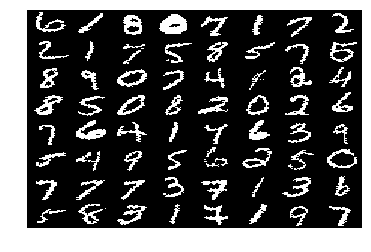

In [11]:
#Real image
data=np.array(next(iter(dataloader["Train"]))[0][:64].view(-1,28,28))
i=0
f, axarr = plt.subplots(8,8, gridspec_kw={'wspace':0, 'hspace':0})
for row in range(8):
    for col in range(8):
        axarr[row, col].imshow(data[i], cmap='binary_r', aspect='auto')
        axarr[row, col].axis("off")
        i += 1

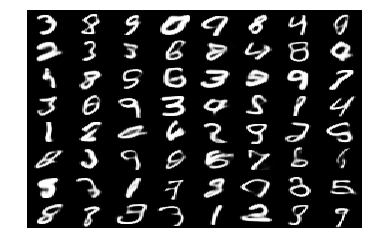

In [15]:
#generated sample
z =torch.randn((64,100), device=device)
image = F.sigmoid(model._decoder(z))
data=image.view(-1,28,28).cpu().detach().numpy()
i=0
f, axarr = plt.subplots(8,8, gridspec_kw={'wspace':0, 'hspace':0})
for row in range(8):
    for col in range(8):
        axarr[row, col].imshow(data[i], cmap='binary_r', aspect='auto')
        axarr[row, col].axis("off")
        i += 1